In [58]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd

from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Our very own survLime!
import survLime
from survLime.datasets import load_datasets
from survLime import survlime_tabular


x,y = load_datasets.Loader('veteran')
names = ['celltype_'+name for name in x.celltype.unique()]
x[names] = pd.get_dummies(x.celltype)
x.drop('celltype', inplace=True, axis=1)
get_target = lambda df: df[['status','time']]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
X_train, X_test, y_train, y_test = train_test_split(x.copy(), y, test_size=0.05, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test.copy(), y_test, test_size=0.5, random_state=1)
scaler = StandardScaler()

X_train_processed = pd.DataFrame(data=scaler.fit_transform(X_train, y_train),
                                 columns=X_train.columns, index=X_train.index)

X_test_t = pd.DataFrame(data=scaler.transform(X_test),
                                 columns=X_test.columns, index=X_test.index)

#print(hasattr(scaler, "n_features_in_"))
events_train = [x[0] for x in y_train]
times_train  = [x[1] for x in y_train]

events_val = [x[0] for x in y_val]
times_val  = [x[1] for x in y_val]

events_test = [x[0] for x in y_test]
times_test  = [x[1] for x in y_test]

y_train = Surv.from_arrays(events_train, times_train)
y_val   = Surv.from_arrays(events_val, times_val)
y_test  = Surv.from_arrays(events_test, times_test)


In [118]:
model = CoxPHSurvivalAnalysis()
#model = RandomSurvivalForest()
model.fit(X_train_processed, y_train)
model.score(X_train_processed.copy(), y_train)

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.51205e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=7.75565e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.68509e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.1072e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.p

0.7374952513612765

In [119]:
def fill_matrix(total_times, matrix, event_times):
    gl = []
    for time in total_times:
        if time in event_times:
            time_index = event_times.index(time)
            gl.append(matrix[time_index])
        else:
            gl.append(gl[-1])
    return gl



def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) 

In [120]:
from sksurv.nonparametric import nelson_aalen_estimator
from functools import partial
import cvxpy as cp
from math import log
import timeit
import sklearn

# Step one
Ho_t_ = nelson_aalen_estimator(events_train, times_train)[0] # Unique times [0]; CHF [1]


columns = X_test.columns.tolist()
num_pat = 500

# Step two
explainer = survlime_tabular.LimeTabularExplainer(X_train_processed, feature_names=columns, class_names=None,
                                                   categorical_features=None, verbose=True, mode='regression', discretize_continuous=False)

synthetic_data = explainer.data_inverse(X_train_processed.iloc[0], num_pat) # At [0] we have the data and at [1]
                                                        #the inverse, see what is this
    
# Third step: Obtain the prediction for the synthetic data 
H_i_j = model.predict_cumulative_hazard_function(synthetic_data[1]) # X_test_t -> [371, num_features]
times_to_fill = list(set(times_train))
H_i_j[0]
H_i_j_wc = [fill_matrix(times_to_fill, x.y, list(x.x)) for x in H_i_j]

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but CoxPHSurvivalAnalysis was fitted with feature names
  warnings.warn(


In [121]:
explainer.scaler

StandardScaler(with_mean=False)

In [122]:
kernel_fn = partial(kernel, kernel_width=5)

# We need to do the line 362 from survlime_tabular (scale the data)
scaled_data = synthetic_data[0] # We need to scale this
scaled_data_ = (scaled_data - explainer.scaler.mean_) / explainer.scaler.scale_
distances = sklearn.metrics.pairwise_distances(
            scaled_data,
            scaled_data[0].reshape(1,-1), # <-- Point of inquiry
            metric = 'euclidean').ravel()
weights = kernel_fn(distances)

In [123]:
scaled_data[0]

array([ 0.9696899 ,  0.025794  , -0.51738488, -0.01296483, -0.64268459,
       -0.51199211, -0.5       , -0.7152817 ,  1.71446608])

In [124]:
scaled_data_[0]

array([ 0.9696899 ,  0.025794  , -0.51738488, -0.01296483, -0.64268459,
       -0.51199211, -0.5       , -0.7152817 ,  1.71446608])

In [ ]:
start_time = timeit.default_timer()
# code you want to evaluate
timeit.default_timer() - start_time

epsilon = 0.00000001
n = 9 # For now we are only using 3 features
num_times = len(set(times_to_fill))-1
b = cp.Variable(n)


# We are having Conconcave problems here!!
cost = [weights[k]*cp.sum_squares((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]))\
        for k in range(num_pat) for j in range(num_times)] # *(times_to_fill[j+1]-times_to_fill[j])
#cost = [weights[k]*cp.norm((log(H_i_j_wc[k][j]+epsilon) - log(Ho_t_[j]+epsilon) - b @ scaled_data[k]),'inf') \
#                                            for k in range(num_pat) for j in range(num_times)]
print(f'time creating the cost list {timeit.default_timer() - start_time}')

start_time = timeit.default_timer()
cost_sum = cp.sum(cost)

print(f'time summing the cost list {timeit.default_timer() - start_time}')
start_time = timeit.default_timer()

prob = cp.Problem(cp.Minimize(cost_sum))


opt_val = prob.solve(verbose=True)
print(f'time solving the problem {timeit.default_timer() - start_time}')
b.value

In [36]:
df = pd.DataFrame(columns=model.feature_names_in_, 
                  data=[b.value, model.coef_], index=['SurvLIME','CoxPH'])
type(model)
isinstance(model, CoxPHSurvivalAnalysis)
df.transpose()['SurvLIME']

trt                  -0.152458
karno                -0.184187
diagtime              0.011751
age                   0.110954
prior                -0.073220
celltype_squamous    -0.464872
celltype_smallcell    0.263472
celltype_adeno        0.344233
celltype_large        0.031922
Name: SurvLIME, dtype: float64

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.51205e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=7.75565e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.68509e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.1072e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.p

> /home/carlos.hernandez/PhD/SurvLIME/survLime/utils/generic_utils.py(33)fill_matrix_with_total_times()
     32     gl = []
---> 33     for time in total_times:
     34         if time in event_times:



ipdb>  c


> /home/carlos.hernandez/PhD/SurvLIME/survLime/utils/generic_utils.py(33)fill_matrix_with_total_times()
     32     gl = []
---> 33     for time in total_times:
     34         if time in event_times:



ipdb>  gl


[0.9719047619047619, 0.9719047619047619, 0.9719047619047619, 0.9719047619047619, 0.9627380952380952, 0.9627380952380952, 0.9607380952380953, 0.9607380952380953, 0.9574047619047619, 0.943404761904762, 0.943404761904762, 0.943404761904762, 0.943404761904762, 0.943404761904762, 0.9409047619047619, 0.9409047619047619, 0.9372380952380952, 0.9372380952380952, 0.9372380952380952, 0.920892857142857, 0.920892857142857, 0.8985476190476188, 0.8985476190476188, 0.8985476190476188, 0.8870476190476189, 0.8870476190476189, 0.871880952380952, 0.871880952380952, 0.871880952380952, 0.871880952380952, 0.866880952380952, 0.8451309523809521, 0.8402142857142855, 0.8377142857142854, 0.8377142857142854, 0.8377142857142854, 0.8377142857142854, 0.8377142857142854, 0.8233809523809521, 0.8213809523809522, 0.8213809523809522, 0.8213809523809522, 0.8213809523809522, 0.8213809523809522, 0.814380952380952, 0.8098809523809521, 0.8098809523809521, 0.8073809523809521, 0.8073809523809521, 0.8073809523809521, 0.8057142857

ipdb>  c


> /home/carlos.hernandez/PhD/SurvLIME/survLime/utils/generic_utils.py(33)fill_matrix_with_total_times()
     32     gl = []
---> 33     for time in total_times:
     34         if time in event_times:



ipdb>  c


> /home/carlos.hernandez/PhD/SurvLIME/survLime/utils/generic_utils.py(87)compare_survival_times()
     86         import ipdb;ipdb.set_trace()
---> 87         plt.step(preds_survlime[0].x, preds_bb_y, where="post", label='BB model')
     88         plt.step(preds_survlime[0].x, preds_surv_y, where="post", label='SurvLIME')



ipdb>  c


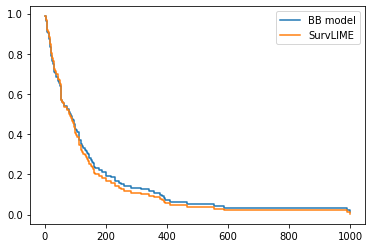

In [117]:
from survLime.utils.generic_utils import compare_survival_times

compare_survival_times(model, b.value, X_train_processed, y_train, X_train_processed)

In [96]:
model.predict_survival_function(X_train_processed)[0].x.__len__()

ValueError: Found input variables with inconsistent numbers of samples: [97, 93]

In [161]:
import matplotlib.pyplot as plt
model_2 = CoxPHSurvivalAnalysis()
model_2.fit(X_train_processed, y_train)
model_2.coef_ = b.value

/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=4.66642e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=6.05059e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=4.04011e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=5.05028e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.

In [162]:
preds_cox      = model.predict_survival_function(X_test_t)
preds_survlime = model_2.predict_survival_function(X_test_t)

preds_cox_y  = [x.y for x in preds_cox]
preds_surv_y = [x.y for x in preds_survlime]

In [163]:
len(preds_cox_y)
prueba = np.mean(preds_cox_y, axis=0)
prueba_surv = np.mean(preds_surv_y, axis=0)

In [186]:
type(X_test_t)

pandas.core.frame.DataFrame

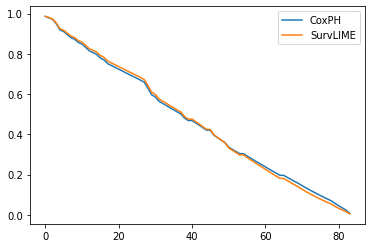

In [181]:
plt.plot(prueba, label='CoxPH')
plt.plot(prueba_surv, label='SurvLIME')
plt.legend()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=3.96842e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=9.98832e-18): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=1.52627e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,
/home/carlos.hernandez/dl/lib/python3.8/site-packages/sksurv/linear_model/coxph.py:433: LinAlgWarning: Ill-conditioned matrix (rcond=2.03557e-17): result may not be accurate.
  delta = solve(optimizer.hessian, optimizer.gradient,


NameError: name 'b' is not defined